<a href="https://colab.research.google.com/github/thimotyb/real-world-machine-learning/blob/python3/ReinforcementLearning_NChain_OpenGym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning
## Open-AI Gym n-chain example with neural networks
[link text](https://adventuresinmachinelearning.com/reinforcement-learning-tutorial-python-keras/)

The NChain example on Open AI Gym is a simple 5 state environment. There are two
possible actions in each state, move forward (action 0) and move backwards (action 1).
When action 1 is taken, i.e. move backwards, there is an immediate reward of 2 given to
the agent – and the agent is returned to state 0 (back to the beginning of the chain).
However, when a move forward action is taken (action 0), there is no immediate reward
until state 4. When the agent moves forward while in state 4, a reward of 10 is received by
the agent. The agent stays in state 4 at this point also, so the reward can be repeated.
There is also a random chance that the agent’s action is “flipped” by the environment (i.e.
an action 0 is flipped to an action 1 and vice versa). The diagram below demonstrates this
environment:

![alt text](https://adventuresinmachinelearning.com/wp-content/uploads/2018/02/NChain-illustration.png)

Reinforcement learning – the basics
Reinforcement learning can be considered the third genre of the machine learning triad – unsupervised learning, supervised learning and reinforcement learning. In supervised learning, we supply the machine learning system with curated (x, y) training pairs, where the intention is for the network to learn to map x to y. In reinforcement learning, we create an agent which performs actions in an environment and the agent receives various rewards depending on what state it is in when it performs the action. In other words, an agent explores a kind of game, and it is trained by trying to maximize rewards in this game. This cycle is illustrated in the figure below:

![alt text](https://i2.wp.com/adventuresinmachinelearning.com/wp-content/uploads/2018/02/Reinforcement-learning-environment.png?w=381&ssl=1)

As can be observed above, the agent performs some action in the environment. An interpreter views this action in the environment, and feeds back an updated state that the agent now resides in, and also the reward for taking this action. The environment is not known by the agent beforehand, but rather it is discovered by the agent taking incremental steps in time. So, for instance, at time t the agent, in state ,  may take action a. This results in a new state  and a reward r. This reward can be a positive real number, zero, or a negative real number. It is the goal of the agent to learn which state dependent action to take which maximizes its rewards. The way which the agent optimally learns is the subject of reinforcement learning theory and methodologies.

To more meaningfully examine the theory and possible approaches behind reinforcement learning, it is useful to have a simple example in which to work through. This simple example will come from an environment available on Open AI Gym called NChain.

## Playing with Gym

The step() command returns 4 variables in a tuple, these are (in order):

The new state after the action
The reward due to the action
Whether the game is “done” or not – the NChain game is done after 1,000 steps
Debugging information – not relevant in this example

In [15]:
# Prepare the Gym
import gym
import numpy as np
env = gym.make('NChain-v0')
env.reset()

0

In [12]:
# Simulate a few steps of the game
print(env.step(1))
print(env.step(0))
print(env.step(0))
print(env.step(0))
print(env.step(0))
print(env.step(0))
print(env.step(0))
print(env.step(0))
print(env.step(0)) # Reaches the max reward in the game
print(env.step(0))
print(env.step(0))

(0, 2, False, {})
(1, 0, False, {})
(2, 0, False, {})
(3, 0, False, {})
(4, 0, False, {})
(0, 2, False, {})
(1, 0, False, {})
(2, 0, False, {})
(3, 0, False, {})
(4, 0, False, {})
(4, 10, False, {})


As can be observed, starting in state 0 and taking step(1) action, the agent stays in state 0 and gets 2 for its reward. Next, I sent a series of action 0 commands. After every action 0 command, we would expect the progression of the agent along the chain, with the state increasing in increments (i.e. 0 -> 1 -> 2 etc.). However, you’ll observe after the first step(0) command, that the agent stays in state 0 and gets a 2 reward. This is because of the random tendency of the environment to “flip” the action occasionally, so the agent actually performed a 1 action. This is just unlucky.

Nevertheless, I persevere and it can be observed that the state increments as expected, but there is no immediate reward for doing so for the agent until it reaches state 4. When in state 4, an action of 0 will keep the agent in step 4 and give the agent a 10 reward. Not only that, the environment allows this to be done repeatedly, as long as it doesn’t produce an unlucky “flip”, which would send the agent back to state 0 – the beginning of the chain.

# A first naive heuristic for reinforcement learning

In order to train the agent effectively, we need to find a good policy pi which maps states to actions in an optimal way to maximize reward. There are various ways of going about finding a good or optimal policy, but first, let’s consider a naive approach.

Let’s conceptualize a table, and call it a reward table, which looks like this:



$\begin{bmatrix}r_{s_0,a_0} & r_{s_0,a_1}\\ r_{s_1,a_0} & r_{s_1,a_1} \\
r_{s_2,a_0} & r_{s_2,a_1} \\
r_{s_3,a_0} & r_{s_3,a_1} \\
r_{s_4,a_0} & r_{s_4,a_1} \end{bmatrix}$



Each of the rows corresponds to the 5 available states in the NChain environment, and each column corresponds to the 2 available actions in each state – forward and backward, 0 and 1. The value in each of these table cells corresponds to some measure of reward that the agent has “learnt” occurs when they are in that state and perform that action. So, the value  would be, say, the sum of the rewards that the agent has received when in the past they have been in state 0 and taken action 0. This table would then let the agent choose between actions based on the summated (or average, median etc. – take your pick) amount of reward the agent has received in the past when taking actions 0 or 1.

This might be a good policy – choose the action resulting in the greatest previous summated reward. Let’s give it a try, the code looks like:

In [0]:
def naive_sum_reward_agent(env, num_episodes=500):
    # this is the table that will hold our summated rewards for
    # each action in each state
    r_table = np.zeros((5, 2))
    for g in range(num_episodes):
        s = env.reset()
        done = False
        while not done:
            if np.sum(r_table[s, :]) == 0:
                # make a random selection of actions
                a = np.random.randint(0, 2)
            else:
                # select the action with highest cummulative reward
                a = np.argmax(r_table[s, :])
            new_s, r, done, _ = env.step(a)
            r_table[s, a] += r
            s = new_s
    return r_table

In the function definition, the environment is passed as the first argument, then the number of episodes (or number of games) that we will train the r_table on. We first create the r_table matrix which I presented previously and which will hold our summated rewards for each state and action. Then there is an outer loop which cycles through the number of episodes. The env.reset() command starts the game afresh each time a new episode is commenced. It also returns the starting state of the game, which is stored in the variable s.

The second, inner loop continues until a “done” signal is returned after an action is passed to the environment. The if statement on the first line of the inner loop checks to see if there are any existing values in the r_table for the current state – it does this by confirming if the sum across the row is equal to 0. If it is zero, then an action is chosen at random – there is no better information available at this stage to judge which action to take.

This condition will only last for a short period of time. After this point, there will be a value stored in at least one of the actions for each state, and the action will be chosen based on which column value is the largest for the row state s. In the code, this choice of the maximum column is executed by the numpy argmax function – this function returns the index of the vector / matrix with the highest value. For example, if the agent is in state 0 and we have the r_table with values [100, 1000] for the first row, action 1 will be selected as the index with the highest value is column 1.

After the action has been selected and stored in a, this action is fed into the environment with env.step(a). This command returns the new state, the reward for this action, whether the game is “done” at this stage and the debugging information that we are not interested in. In the next line, the r_table cell corresponding to state s and action a is updated by adding the reward to whatever is already existing in the table cell.

Finally the state s is updated to new_s – the new state of the agent.

If we run this function, the r_table will look something like:

In [17]:
naive_sum_reward_agent(env)

array([[     0., 560672.],
       [ 27824.,      0.],
       [     0.,  90460.],
       [     0.,  18164.],
       [ 91168.,      0.]])

Examining the results above, you can observe that the most common state for the agent to be in is the first state, seeing as any action 1 will bring the agent back to this point. The least occupied state is state 4, as it is difficult for the agent to progress from state 0 to 4 without the action being “flipped” and the agent being sent back to state 0. You can get different results if you run the function multiple times, and this is because of the stochastic nature of both the environment and the algorithm.

Clearly – something is wrong with this table. One would expect that in state 4, the most rewarding action for the agent would be to choose action 0, which would reward the agent with 10 points, instead of the usual 2 points for an action of 1. Not only that, but it has chosen action 0 for all states – this goes against intuition – surely it would be best to sometimes shoot for state 4 by choosing multiple action 0’s in a row, and that way reap the reward of multiple possible 10 scores.

In fact, there are a number of issues with this way of doing reinforcement learning:

First, once there is a reward stored in one of the columns, the agent will always choose that action from that point on. This will lead to the table being “locked in” with respect to actions after just a few steps in the game.
Second, because no reward is obtained for most of the states when action 0 is picked, this model for training the agent has no way to encourage acting on delayed reward signal when it is appropriate for it to do so.
Let’s see how these problems could be fixed.

## Delayed reward reinforcement learning


Let’s say we are in state 3 – in the previous case, when the agent chose action 0 to get to state 3, the reward was zero and therefore r_table[3, 0] = 0. Obviously the agent would not see this as an attractive step compared to the alternative for this state i.e. r_table[3, 1] >= 2. But what if we assigned to this state the reward the agent would receive if it chose action 0 in state 4? It would look like this: r_table[3, 0] = r + 10 = 10 – a much more attractive alternative!

This idea of propagating possible reward from the best possible actions in future states is a core component of what is called Q learning. In Q learning, the Q value for each action in each state is updated when the relevant information is made available. 

$Q(s, a) = Q(s, a) + \alpha (r + \gamma \max\limits_{a’} Q(s’, a’) – Q(s, a))$

First, as you can observe, this is an updating rule – the existing Q value is added to, not replaced. Ignoring the alpha for the moment, we can concentrate on what’s inside the brackets. The first term, r, is the reward that was obtained when action a was taken in state s. Next, we have an expression which is a bit more complicated. Ignore the gamma for the moment and focus on $\max\limits_{a’} Q(s’, a’)$.

What this means is that we look at the next state s’ after action a and return the maximum possible Q value in the next state. In other words, return the maximum Q value for the best possible action in the next state. In this way, the agent is looking forward to determine the best possible future rewards before making the next step a.

The gamma value is called the discounting factor – this decreases the impact of future rewards on the immediate decision making in state s. This is important, as this represents a limited patience in the agent, so gamma will always be less than 1. The – Q(s, a) term acts to restrict the growth of the Q value as the training of the agent progresses through many iterations. Finally, this whole sum is multiplied by a learning rate alpha which restricts the updating to ensure it doesn’t “race” to a solution – this is important for optimal convergence.

Note that while the learning rule only examines the best action in the following state, in reality, discounted rewards still cascade down from future states. For instance, if we think of the cascading rewards from all the 0 actions (i.e. moving forward along the chain) and start at state 3, the Q reward will be

$r + \gamma \max_a Q(s’, a’) = 0 + 0.95 * 10 = 9.5$

If we work back from state 3 to state 2 it will be 0 + 0.95 * 9.5 = 9.025. Likewise, the cascaded, discounted reward from to state 1 will be 0 + 0.95 * 9.025 = 8.57, and so on. Therefore, while the immediate updating calculation only looks at the maximum Q value for the next state, “upstream” rewards that have previously been discovered by the agent still cascade down into the present state and action decision. This is a simplification, due to the learning rate and random events in the environment, but represents the general idea.

The following is a possible implementation of the QLearning approach:

In [0]:
def q_learning_with_table(env, num_episodes=500):
    q_table = np.zeros((5, 2))
    y = 0.95 # This is the gamma: Agent Patience factor
    lr = 0.8 # This is the learning rate Alpha for convergence
    for i in range(num_episodes):
        s = env.reset()
        done = False
        while not done:
            if np.sum(q_table[s,:]) == 0:
                # make a random selection of actions
                a = np.random.randint(0, 2)
            else:
                # select the action with largest q value in state s
                a = np.argmax(q_table[s, :])
            new_s, r, done, _ = env.step(a)
            # The following line executes the Q learning rule that was presented previously. 
            # The np.max(q_table[new_s, :]) is an easy way of selecting the maximum value in the q_table for the row new_s
            q_table[s, a] += r + lr*(y*np.max(q_table[new_s, :]) - q_table[s, a])
            s = new_s
    return q_table

Let's execute the procedure:

In [20]:
q_learning_with_table(env)

array([[21.27191013,  0.        ],
       [ 0.        , 22.65391096],
       [22.57979851,  0.        ],
       [ 0.        , 27.14367692],
       [28.01788348,  0.        ]])

Again, we would expect at least the state 4 – action 0 combination to have the highest Q score, but it doesn’t.  We might also expect the reward from this action in this state to have cascaded down through the states 0 to 3. **Something has clearly gone wrong** – and the answer is that there isn’t enough exploration going on within the agent training method.

# Q learning with epsilon-greedy action selection

If we think about the previous iteration of the agent training model using Q learning, the action selection policy is based solely on the maximum Q value in any given state. It is conceivable that, given the random nature of the environment, that the agent initially makes “bad” decisions. The Q values arising from these decisions may easily be “locked in” – and from that time forward, bad decisions may continue to be made by the agent because it can only ever select the maximum Q value in any given state, even if these values are not necessarily optimal. This action selection policy is called a greedy policy.

So we need a way for the agent to eventually always choose the “best” set of actions in the environment, yet at the same time allowing the agent to not get “locked in” and giving it some space to explore alternatives. What is required is the epsilon-greedy policy.

The epsilon-greedy policy in reinforcement learning is basically the same as the greedy policy, **except that there is a value  (which may be set to decay over time) where, if a random number is selected which is less than this value, an action is chosen completely at random**. This step allows some random exploration of the value of various actions in various states, and can be scaled back over time to allow the algorithm to concentrate more on exploiting the best strategies that it has found. 

The following is a possible implementation:

In [0]:
def eps_greedy_q_learning_with_table(env, num_episodes=500):
    q_table = np.zeros((5, 2))
    y = 0.95 # This is the gamma: Agent Patience factor
    eps = 0.5 # Random threshold to trigger the Agent for random exploration 
    lr = 0.8 # This is the learning rate Alpha for convergence
    decay_factor = 0.999 # exponentially decays eps with each episode eps *= decay_factor
    for i in range(num_episodes):
        s = env.reset()
        eps *= decay_factor
        done = False
        while not done:
            # select the action with highest cummulative reward
            if np.random.random() < eps or np.sum(q_table[s, :]) == 0:
                # Triggers a random exploration
                a = np.random.randint(0, 2)
            else:
                # Proceed with greedy Q-learning
                a = np.argmax(q_table[s, :])
            # pdb.set_trace()
            new_s, r, done, _ = env.step(a)
            q_table[s, a] += r + lr * (y * np.max(q_table[new_s, :]) - q_table[s, a])
            s = new_s
    return q_table

In [23]:
eps_greedy_q_learning_with_table(env)

array([[62.39645877, 61.04611656],
       [65.92907935, 62.37352545],
       [73.88150447, 63.87966975],
       [66.05076616, 43.55486257],
       [91.35814383, 52.96667128]])

**Finally we have a table which favors action 0 in state 4** – in other words what we would expect to happen given the reward of 10 that is up for grabs via that action in that state. Notice also that, as opposed to the previous tables from the other methods, that there are no actions with a 0 Q value – this is because the full action space has been explored via the randomness introduced by the epsilon-greedy policy.

# Reinforcement learning with Keras

So far, we have been dealing with explicit tables to hold information about the best actions and which actions to choose in any given state. However, while this is perfectly reasonable for a small environment like NChain, the table gets far too large and unwieldy for more complicated environments which have a huge number of states and potential actions.

This is where neural networks can be used in reinforcement learning. Instead of having explicit tables, we can train a neural network to predict Q values for each action in a given state. This will be demonstrated using Keras.

To develop a neural network which can perform Q learning, the input needs to be the current state (plus potentially some other information about the environment) and it needs to output the relevant Q values for each action in that state. The Q values which are output should approach, as training progresses, the values produced in the Q learning updating rule. Therefore, the loss or cost function for the neural network should be:

$\text{loss} = (\underbrace{r + \gamma \max_{a’} Q'(s’, a’)}_{\text{target}} – \underbrace{Q(s, a)}_{\text{prediction}})^2$

The input to the network is the one-hot encoded state vector. For instance, the vector which corresponds to state 1 is [0, 1, 0, 0, 0] and state 3 is [0, 0, 0, 1, 0]. In this case, a hidden layer of 10 nodes with sigmoid activation will be used. The output layer is a linear activated set of two nodes, corresponding to the two Q values assigned to each state to represent the two possible actions. Linear activation means that the output depends only on the linear summation of the inputs and the weights, with no additional function applied to that summation.

The following is the neural network model to be used:


![alt text](https://i0.wp.com/adventuresinmachinelearning.com/wp-content/uploads/2018/03/Reinforcement-learning-Keras.png?zoom=3.5&resize=340%2C335&ssl=1)

We create this NN architecture in Keras:

In [26]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(batch_input_shape=(1, 5)))
model.add(keras.layers.Dense(10, activation='sigmoid'))
model.add(keras.layers.Dense(2, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


First, the model is created using the Keras Sequential API. Then an input layer is added which takes inputs corresponding to the one-hot encoded state vectors. Then the sigmoid activated hidden layer with 10 nodes is added, followed by the linear activated output layer which will yield the Q values for each action. Finally the model is compiled using a mean-squared error loss function (to correspond with the loss function defined previously) with the Adam optimizer being used in its default Keras state.

We now integrate this model in the epsilon-greedy Q-learning approach described above:

In [0]:
def eps_greedy_q_learning_with_neural_network(env, num_episodes=500):
  # now execute the q learning
  y = 0.95
  eps = 0.5
  decay_factor = 0.999
  r_avg_list = []
  for i in range(num_episodes):
      s = env.reset()
      eps *= decay_factor
      if i % 100 == 0:
          print("Episode {} of {}".format(i + 1, num_episodes))
      done = False
      r_sum = 0
      while not done:
          if np.random.random() < eps:
              """
              Usual epsilon-greedy random exploration
              """
              a = np.random.randint(0, 2)
          else:
              """
              The second condition uses the Keras model to produce the two Q values – one for each possible state. 
              It does this by calling the model.predict() function. Here the numpy identity function is used, with vector slicing, 
              to produce the one-hot encoding of the current state s. The standard numpy argmax function is used 
              to select the action with the highest Q value returned from the Keras model prediction.
              """
              a = np.argmax(model.predict(np.identity(5)[s:s + 1]))
          new_s, r, done, _ = env.step(a)
          # Model Updating
          target = r + y * np.max(model.predict(np.identity(5)[new_s:new_s + 1]))
          target_vec = model.predict(np.identity(5)[s:s + 1])[0]
          target_vec[a] = target
          model.fit(np.identity(5)[s:s + 1], target_vec.reshape(-1, 2), epochs=1, verbose=0)
          s = new_s
          r_sum += r
      r_avg_list.append(r_sum / 1000)
  return r_avg_list

Model updating is the main difference with the previous approach.

The first line sets the target as the Q learning updating rule that has been previously presented. It is the reward r plus the discounted maximum of the predicted Q values for the new state, new_s. This is the value that we want the Keras model to learn to predict for state s and action a i.e. Q(s,a). However, our Keras model has an output for each of the two actions – we don’t want to alter the value for the other action, only the action a which has been chosen. So on the next line, target_vec is created which extracts both predicted Q values for state s. On the following line, only the Q value corresponding to the action a is changed to target – the other action’s Q value is left untouched.

The final line is where the Keras model is updated in a single training step. The first argument is the current state – i.e. the one-hot encoded input to the model. The second is our target vector which is reshaped to make it have the required dimensions of (1, 2). The third argument tells the fit function that we only want to train for a single iteration and finally the verbose flag simply tells Keras not to print out the training progress.

In [55]:
num_episodes = 500
r_avg_list = eps_greedy_q_learning_with_neural_network(env, num_episodes)

Episode 1 of 500
Episode 101 of 500
Episode 201 of 500
Episode 301 of 500
Episode 401 of 500


In [56]:
print(r_avg_list)
x = np.arange(0, num_episodes)
print(x)

[1.354, 1.354, 1.366, 1.37, 1.406, 1.354, 1.416, 1.378, 1.34, 1.334, 1.366, 1.398, 1.37, 1.33, 1.378, 1.406, 1.318, 1.322, 1.374, 1.394, 1.32, 1.42, 1.306, 1.376, 1.592, 1.65, 1.586, 1.646, 2.142, 1.776, 1.892, 1.556, 1.716, 1.854, 1.774, 1.926, 2.206, 1.746, 1.938, 1.746, 1.842, 1.79, 1.758, 2.062, 1.572, 1.846, 2.434, 1.992, 1.966, 2.092, 1.882, 2.094, 1.79, 1.768, 1.62, 2.1, 2.16, 2.092, 1.83, 1.67, 1.694, 1.884, 1.944, 1.782, 2.158, 1.828, 1.934, 2.194, 2.31, 2.0, 2.178, 2.114, 1.696, 1.906, 2.05, 2.122, 2.036, 2.194, 1.994, 2.11, 2.086, 2.18, 1.874, 1.862, 2.008, 2.22, 2.174, 1.89, 1.938, 1.826, 1.942, 2.352, 2.23, 2.112, 2.09, 1.992, 1.868, 2.034, 2.076, 2.016, 1.976, 1.926, 1.906, 1.954, 1.836, 1.922, 1.794, 1.948, 1.696, 1.902, 1.812, 1.92, 2.536, 2.026, 1.782, 1.778, 1.874, 2.036, 2.142, 2.29, 2.07, 1.952, 1.788, 2.078, 2.266, 2.218, 1.974, 2.134, 1.794, 1.768, 1.768, 1.788, 1.844, 1.884, 1.938, 1.948, 2.004, 2.054, 2.416, 2.14, 1.892, 1.902, 2.178, 2.166, 2.134, 2.074, 2.336,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


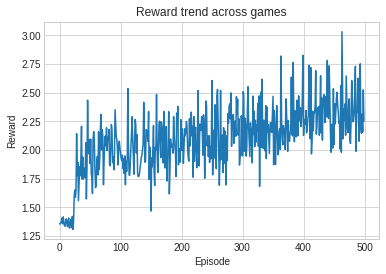

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
plt.title("Reward trend across games")
ax = plt.axes()
ax.set_ylabel("Reward")
ax.set_xlabel("Episode")
ax.plot(x, r_avg_list);